# MS Stock Forecasting

In [170]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

In [171]:
# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [172]:
data = pd.read_csv("../../data/ms_stock_forecasting.csv")
data.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [174]:
data.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


## Open and Close Prices of time

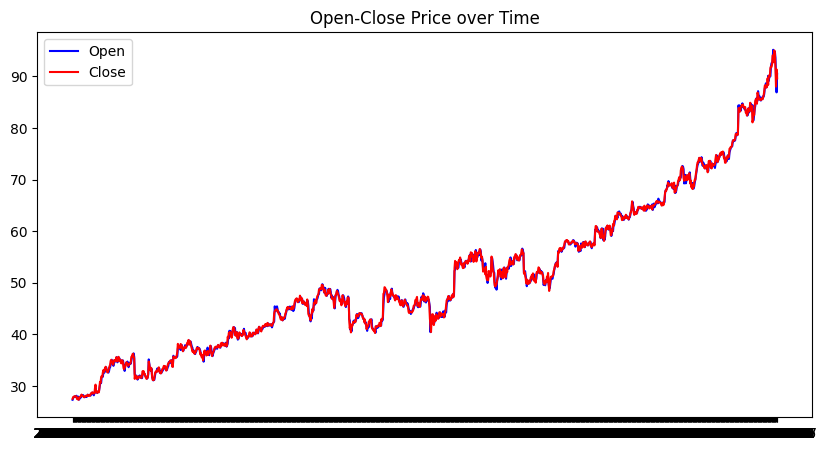

In [175]:
# Initial Data Visualization
plt.figure(figsize=(10,5))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

## Trading Volume

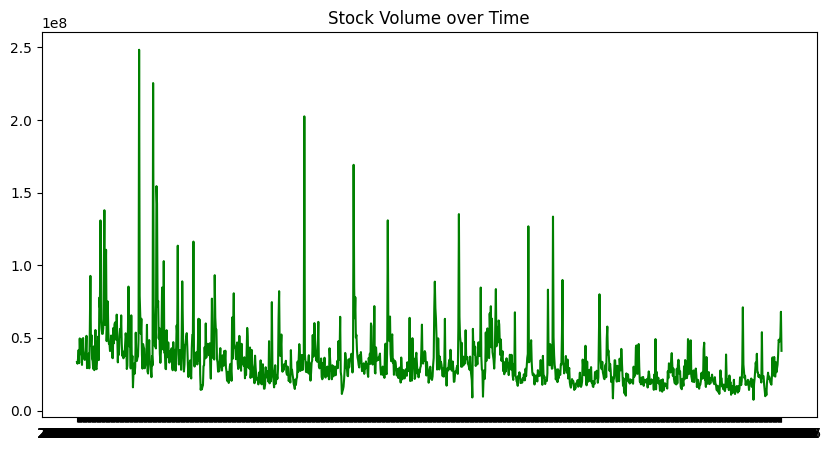

In [176]:
plt.figure(figsize=(10,5))
plt.plot(data['date'],data['volume'],label="Volume",color="green")
plt.title("Stock Volume over Time")
plt.show()

In [177]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

## Check for correlation between features

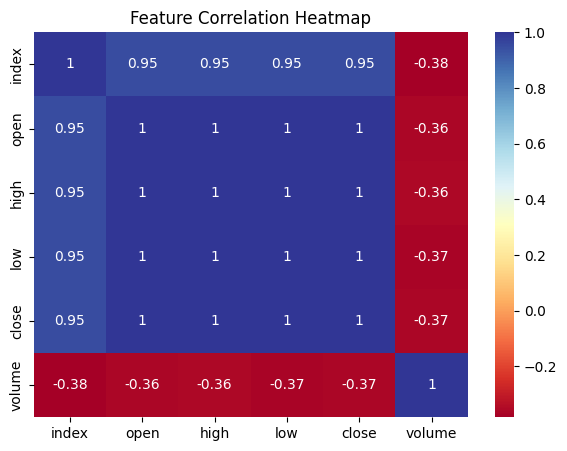

In [178]:
plt.figure(figsize=(7,5))
sns.heatmap(numeric_data.corr(), annot=True, cmap="RdYlBu")
plt.title("Feature Correlation Heatmap")
plt.show()

In [179]:
# Convert the Data into Date time then create a date filter
data['date'] = pd.to_datetime(data['date'])

In [180]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) &
    (data['date'] < datetime(2018,1,1))
]

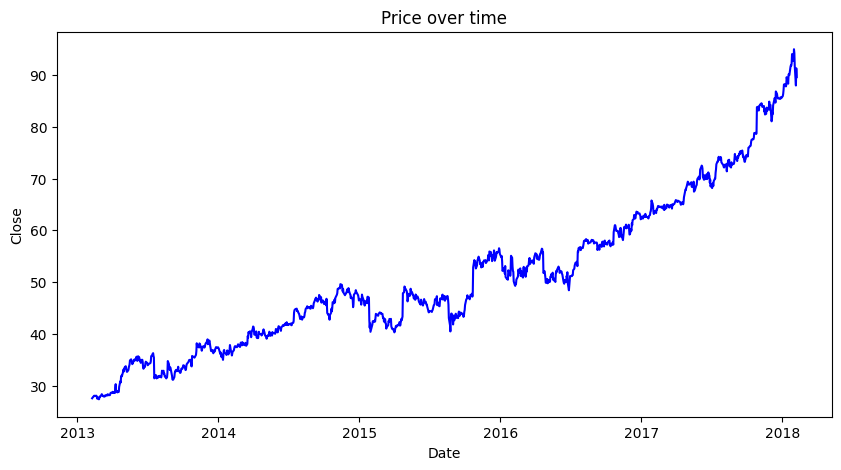

In [181]:
plt.figure(figsize=(10,5))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")
plt.show()

In [182]:
# Prepare for the LSTM Model (Sequential)
stock_close = data.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [183]:
# Preprocessing Stages
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [184]:
#95% of all our data
training_data = scaled_data[:training_data_len] 

X_train, y_train = [], []

In [185]:
# Create a sliding window for our stock (90 days)
for i in range(180, len(training_data)):
    X_train.append(training_data[i-180:i, 0])
    y_train.append(training_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [186]:
# Build the Model
model = keras.models.Sequential()
# Input Layer
model.add(keras.Input(shape=(X_train.shape[1], 1)))
# First Layer
model.add(keras.layers.LSTM(64, return_sequences=True))
# Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))
# 3rd Layer (Dense)
model.add(keras.layers.Dense(128, activation="relu"))
# 4th Layer (Dropout)
model.add(keras.layers.Dropout(0.5))
# Final Output Layer
model.add(keras.layers.Dense(1, activation="linear"))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 180, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
)

In [ ]:
# Define EarlyStopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_rmse',       # what to watch
    mode='min',               # We want to minimize RMSE
    patience=10,              # wait 10 epochs after no improvement
    restore_best_weights=True # roll back to best model
)


In [189]:
history = model.fit(
    X_train, y_train, 
    validation_split=0.2,
    epochs=200, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.2284 - rmse: 0.2989 - val_loss: 0.2769 - val_rmse: 0.3497
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.1177 - rmse: 0.1525 - val_loss: 0.4453 - val_rmse: 0.4915
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.1015 - rmse: 0.1340 - val_loss: 0.2979 - val_rmse: 0.3446
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0996 - rmse: 0.1308 - val_loss: 0.1328 - val_rmse: 0.1824
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0952 - rmse: 0.1245 - val_loss: 0.1037 - val_rmse: 0.1510
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0919 - rmse: 0.1216 - val_loss: 0.0783 - val_rmse: 0.1163
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0890 - rmse: 0.1177 - val_loss: 0.1206 - val_rmse: 0.1612
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0887 - rmse: 0.1153 - val_loss: 0.2077 - val_rmse: 0.2357
Epoch 9/200
13/13 ━━━━━━━━━━━━━━

In [190]:
# Prepare the test data
test_data = scaled_data[training_data_len - 180:]
X_test, y_test = [], dataset[training_data_len:]


In [191]:
for i in range(180, len(test_data)):
    X_test.append(test_data[i-180:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [192]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


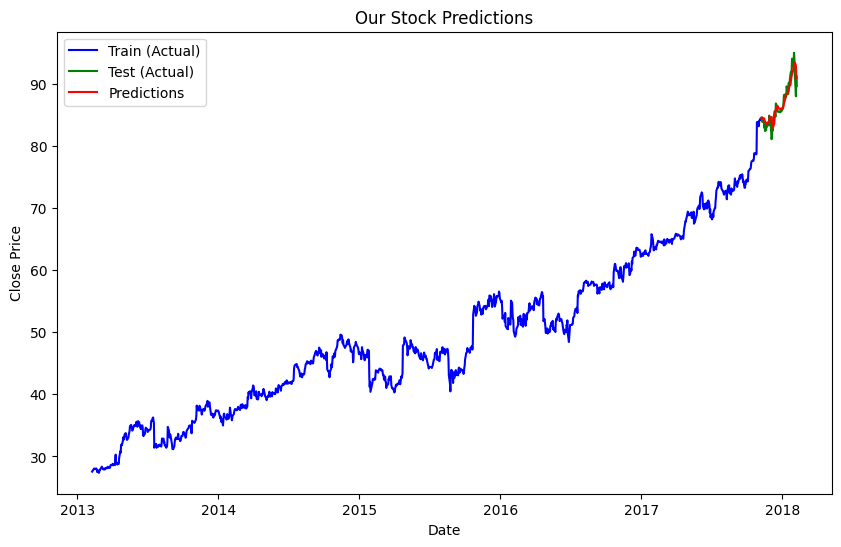

In [194]:
# Plotting data
train = data[:training_data_len]
test =  data[training_data_len:]

test = test.copy()

test['Predictions'] = predictions

plt.figure(figsize=(10,6))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='green')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()